# What is Positive-Semi-Definitness?

Basically its a matrix who's eigenvalues are non-negative. All real covariance/correlation matrices are PSD. If a covariance/correlation is not PSD it means that in order to achieve the pattern of off-diagonal covariances that are observed, it would require some negative variances down the main diagonal. Remember it's mathematically **impossible** for variance to be negative based on how it's is calculated. Thus if a is not PSD, it's not a valid covariance/correlation matrix that arose from real data. Incorrect permutation can produce these kinds of matrices. 

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymer4.simulate import easy_multivariate_normal
from pymer4.utils import _nearestPD, _isPD
from nltools.data import Adjacency
from scipy.spatial.distance import squareform,pdist
from statsmodels.stats.correlation_tools import corr_nearest
from scipy.stats import truncnorm
from matplotlib.colors import ListedColormap
from pymer4.utils import _isPD
% matplotlib inline

# 2 group ISC permutation test

In [363]:
# Generate data with known correlation and visualize it
X = easy_multivariate_normal(500,6,corrs = [.2,.7,0.1,-.1,.02,.7,0,.08,-.08,0,0,0,.15,.2,.1],)
C = pd.DataFrame(X).corr()

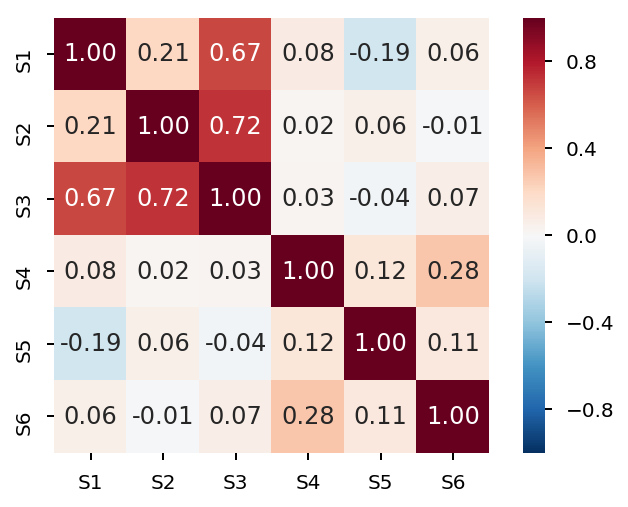

In [364]:
# Here image 2 groups and S1-S3 come from group 1 and S4-S6 from group 2
sns.set_context('notebook');
sns.heatmap(C,square=True,vmin=-1,vmax=1,cmap='RdBu_r',annot=True,fmt='.2f',
            xticklabels=['S1','S2','S3','S4','S5','S6'],
            yticklabels=['S1','S2','S3','S4','S5','S6'])

In [381]:
# Just visualize what we want to compare
vec = Adjacency(np.array([1,1,.25,.25,.25,1,.25,.25,.25,.25,.25,.25,1,1,1]))
labels = squareform(np.array(['21',31,41,51,61,32,42,52,62,43,53,63,54,64,65]))
np.fill_diagonal(labels,'')

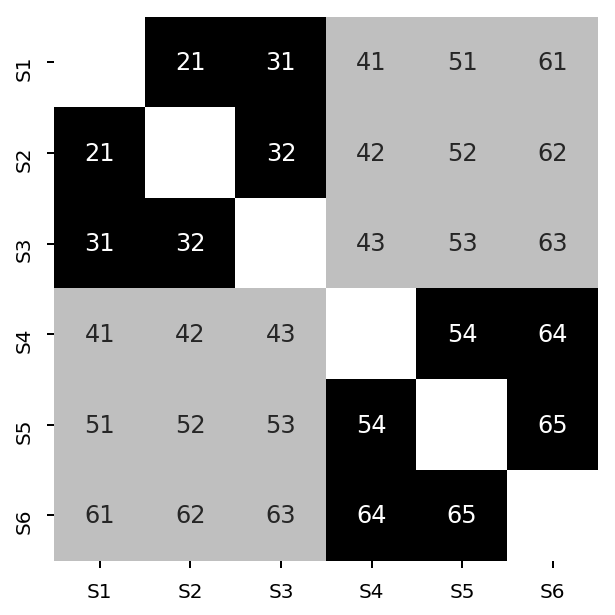

In [382]:
# Recreate schematic figure from Chen et al, 2016
# Within groups are in black and between groups are in gray
# Cell values just reflect the indices of who's getting compared to who (important to see what breaks later)
# i.e. 21 means subjects 2 and 1 are getting compared 
_=vec.plot(cmap='gray_r',cbar=False,annot=labels,fmt='',
          xticklabels=['S1','S2','S3','S4','S5','S6'],
          yticklabels=['S1','S2','S3','S4','S5','S6'])

In [367]:
# Index in to grab the group values and compute the lower triangle means and diffs
n1,n2 = 3,3
g1 = C.iloc[:n1,:n2].values
g2 = C.iloc[n1:,n2:].values
g1g2 = C.iloc[n1:,:n2].values
print(f'Mean G1: {lower(g1).mean()}')
print(f'Mean G2: {lower(g2).mean()}')
print(f'Mean G1&G2: {np.hstack([lower(g1),lower(g2)]).mean()}')
print(f'Mean G1<->G2: {g1g2.mean()}')

Mean G1: 0.5325524943368766
Mean G2: 0.16773322536831806
Mean G1&G2: 0.3501428598525973
Mean G1<->G2: 0.008328544692568452


In [256]:
print(f"G1 > G2 = {lower(g1).mean() - lower(g2).mean()}")
print(f"G1&G2 > G1<->G2 = {np.hstack([lower(g1),lower(g2)]).mean() - g1g2.mean()}")

G1 > G2 = 0.41447305849345895
G1&G2 > G1<->G2 = 0.34801318927329966


## Bad shuffling!
Shuffle the lower triangle of this entire matrix such that some between group cells appear in the "mini-lower triangle" of each group. This *seems* correct, but pay attention to how rows and columns no longer correspond.
This violates PSD!

In [385]:
# Shuffle just the label matrix so it's really clear
# Generate random vector to sort lower triangle by
idx = np.random.permutation(len(vec.data))
vec_shuff = vec.copy()
vec_shuff.data= vec_shuff.data[idx]
# Shuffle annotation labels too for visualization
labels_shuff = np.array(['21',31,41,51,61,32,42,52,62,43,53,63,54,64,65])
labels_shuff = squareform(labels_shuff[idx])
np.fill_diagonal(labels_shuff,'')

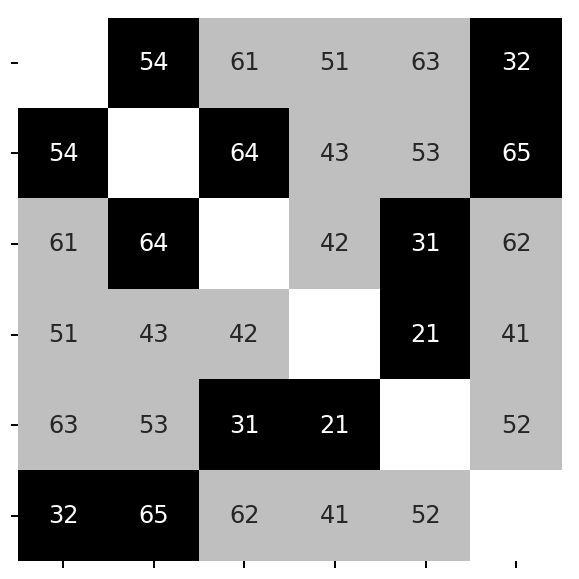

In [387]:
# Notice how reading across a row, or down a column isn't consistent with respect the subject identifiers
_=vec_shuff.plot(cmap='gray_r',cbar=False,annot=labels_shuff,fmt='',
          xticklabels=['','','','','',''],
          yticklabels=['','','','','',''])

In [388]:
# Shuffling the original data matrix using this strategy breaks PSD
c = lower(C.values)[idx]
_isPD(c) # function check for PSD using valid cholesky decomposition from pymer4

False

# Good shuffling
Need to shuffle both rows and columns simultaneously, i.e. 2d-permutation, to respect structure of each sub-matrix. 

In [392]:
vec_shuff_good = vec.copy()
# Now create a permutation array that's the the size of one of the *sides* correlation matrix, *not* the entire bottom triangle
idx = np.random.permutation(vec_shuff_good.squareform().shape[0])

# Shuffle both the data and labels (for plotting) in 2d; easier with pandas 
vec2d = pd.DataFrame(vec_shuff_good.squareform())
labels2d = squareform(np.array(['21',31,41,51,61,32,42,52,61,43,53,63,54,64,65]))
np.fill_diagonal(labels2d,'')
labels2d = pd.DataFrame(labels2d)

# KEY PIECE; 2D shuffle
vec2d = vec2d.iloc[idx,idx]
labels2d = labels2d.iloc[idx,idx]

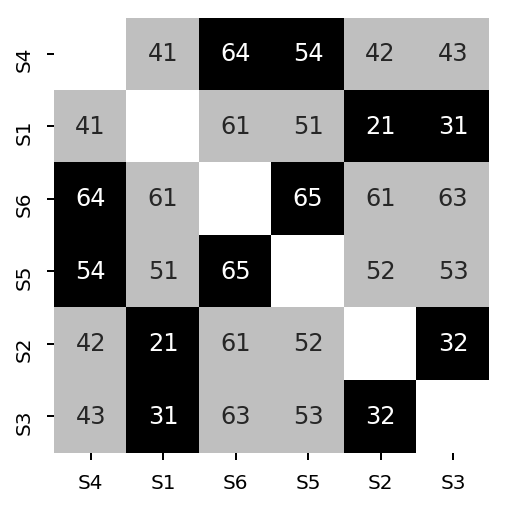

In [405]:
# Notice how now going across a row or down a column contains at least 1 consistent subject
# The way I generate the labels (row,col) doesn't flip the order (i.e. 24 can be 42) but that doesnt matter
# cause correlations between pairs are symmetrical. This is also present in the Chen et al paper
idx_labs = ['S'+str(elem+1) for elem in idx]
sns.heatmap(vec2d,cmap='gray_r',cbar=False,annot=labels2d,fmt='',
          xticklabels= idx_labs,
          yticklabels= idx_labs,square=True)

In [398]:
# Finally check if it's PSD
_isPD(C.iloc[idx,idx])

True

## Other recommendations/intuitions from AFNI paper
- Use median of lower triangle instead of mean because averaging covariances across subjects doesnt make statistical sense since the group variance across subjects is always larger than the mean of each pair of subjects covariances due to between subjects variability 
- Same problem exists with fisher transforming or not